In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
dtrain = np.load('../data/era5_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

# train_mu = np.mean(dtrain, axis = (0))[None,]
# train_sd = np.std(dtrain, axis = (0))[None,]

def clim_smooth(data, kernel):
    return jax.scipy.signal.convolve2d(data, kernel, mode='same')
clim_smooth = jit(vmap(clim_smooth, (0, None)))

kernel = jnp.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]])
kernel = kernel / jnp.sum(kernel)
dtrain = np.array(clim_smooth(dtrain, kernel))

In [3]:
spatial_mean = jnp.mean(dtrain, axis = 0)
spatial_std = jnp.std(dtrain, axis = 0)

dtrain = (dtrain - spatial_mean)/spatial_std

In [5]:
lag, lead = 1, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [7]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno.to(device)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 50
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = torch2jax(fno(jax2torch(xval).to(device)).cpu()).squeeze()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

NameError: name 'xval' is not defined

In [8]:
loss_fn = QuantileLoss(0.9)

fno_quant = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_quant.to(device)
optim_fno = torch.optim.Adam(fno_quant.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_quant(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [9]:
loss_fn = GaussianNLLLoss()

fno_prob = ProbTFNO()
fno_prob.to(device)
optim_fno = torch.optim.Adam(fno_prob.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_prob(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:
n = xtrain.shape[0]
xtrain_base1 = xtrain[:(n//2)]
ytrain_base1 = ytrain[:(n//2)]
xtrain_base2 = xtrain[(n//2):]
ytrain_base2 = ytrain[(n//2):]

train_data1 = TensorDataset(jax2torch(xtrain_base1), jax2torch(ytrain_base1))
train_loader1 = DataLoader(train_data1, batch_size = 30, shuffle = True)

train_data2 = TensorDataset(jax2torch(xtrain_base2), jax2torch(ytrain_base2))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = False)

In [12]:
loss_fn = nn.MSELoss()
fno_base = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_base.to(device)
optim_fno = torch.optim.Adam(fno_base.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader1, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_base(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [13]:
ytrain_base1_hat = []
with torch.no_grad():
    for xt, yt in tqdm(train_loader2, leave = False):
        yt_hat = fno_base(xt.to(device)).cpu().squeeze()
        
        ytrain_base1_hat.append(yt_hat)
ytrain_base1_hat = torch.vstack(ytrain_base1_hat)[:,None]
ytrain_base1_hat = torch2jax(ytrain_base1_hat)

train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2 - ytrain_base1_hat)))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = True)

  0%|          | 0/61 [00:00<?, ?it/s]

In [14]:
loss_fn = QuantileLoss(0.9)
fno_quant2 = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_quant2.to(device)
optim_fno = torch.optim.Adam(fno_quant2.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader2, leave = False): 
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_quant2(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [15]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)

dval = np.array(clim_smooth(dval, kernel))
dtest = np.array(clim_smooth(dtest, kernel))

dval = (dval - spatial_mean)/spatial_std
dtest = (dtest - spatial_mean)/spatial_std

xval, yval = split_data(dval, lag, lead)
xtest, ytest = split_data(dtest, lag, lead)

In [16]:
val_data = TensorDataset(jax2torch(xval), jax2torch(yval))
val_loader = DataLoader(val_data, batch_size = 30, shuffle = True)

test_data = TensorDataset(jax2torch(xtest), jax2torch(ytest))
test_loader = DataLoader(test_data, batch_size = 30, shuffle = False)

In [17]:
with torch.no_grad():
    yval_fno = []
    yval_quant = []
    yval_mu = []
    yval_sd = []
    yval_hat2 = []
    yval_quant2 = []

    ytest_fno = []
    ytest_quant = []
    ytest_mu = []
    ytest_sd = []
    ytest_hat2 = []
    ytest_quant2 = []
    
    for xt, _ in tqdm(val_loader, leave = False):
        xt = jax2torch(xt).to(device)
        
        yval_fno.append(fno(xt).cpu().squeeze())
        yval_quant.append(fno_quant(xt).cpu().squeeze())
        yval_mut, yval_sdt = fno_prob(xt)
        yval_mu.append(yval_mut.cpu().squeeze())
        yval_sd.append(yval_sdt.cpu().squeeze())
        yval_hat2.append(fno_base(xt).cpu().squeeze())
        yval_quant2.append(fno_quant2(xt).cpu().squeeze())
        
    yval_fno = torch2jax(torch.vstack(yval_fno)[:,None])
    yval_quant = torch2jax(torch.vstack(yval_quant)[:,None])
    yval_mu = torch2jax(torch.vstack(yval_mu)[:,None])
    yval_sd = torch2jax(torch.vstack(yval_sd)[:,None])
    yval_hat2 = torch2jax(torch.vstack(yval_hat2)[:,None])
    yval_quant2 = torch2jax(torch.vstack(yval_quant2)[:,None])

    for xt, _ in tqdm(test_loader, leave = False):
        xt = jax2torch(xt).to(device)
        
        ytest_fno.append(fno(xt).cpu().squeeze())
        ytest_quant.append(fno_quant(xt).cpu().squeeze())
        ytest_mut, ytest_sdt = fno_prob(xt)
        ytest_mu.append(ytest_mut.cpu().squeeze())
        ytest_sd.append(ytest_sdt.cpu().squeeze())
        ytest_hat2.append(fno_base(xt).cpu().squeeze())
        ytest_quant2.append(fno_quant2(xt).cpu().squeeze())

    ytest_fno = torch2jax(torch.vstack(ytest_fno)[:,None])
    ytest_quant = torch2jax(torch.vstack(ytest_quant)[:,None])
    ytest_mu = torch2jax(torch.vstack(ytest_mu)[:,None])
    ytest_sd = torch2jax(torch.vstack(ytest_sd)[:,None])
    ytest_hat2 = torch2jax(torch.vstack(ytest_hat2)[:,None])
    ytest_quant2 = torch2jax(torch.vstack(ytest_quant2)[:,None])

rval_fno = yval - yval_fno
rtest_fno = ytest - ytest_fno
rtest_fno2 = ytest - ytest_hat2
rtest_mu = ytest - ytest_mu
# _, nlat, nlon = rval_fno.shape

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [18]:
rval_fno = rval_fno.reshape(-1, nlat*nlon)
rtest_fno = rtest_fno.reshape(-1, nlat*nlon)
rtest_fno2 = rtest_fno2.reshape(-1, nlat*nlon)
rtest_mu = rtest_mu.reshape(-1, nlat*nlon)

yval_quant = yval_quant.reshape(-1, nlat*nlon)
yval_hat2 = yval_hat2.reshape(-1, nlat*nlon)
yval_quant2  = yval_quant2.reshape(-1, nlat*nlon)
ytest_quant2  = ytest_quant2.reshape(-1, nlat*nlon)

yval = yval.reshape(-1, nlat*nlon)
yval_mu = yval_mu.reshape(-1, nlat*nlon)
yval_sd = yval_sd.reshape(-1, nlat*nlon)
ytest_mu  = ytest_mu.reshape(-1, nlat*nlon)
ytest_sd  = ytest_sd.reshape(-1, nlat*nlon)
ytest_quant  = ytest_quant.reshape(-1, nlat*nlon)

In [63]:
nproj = 100
n_samp = 2000
n_phi = 20
alpha = 0.1
nval = rval_fno.shape[1]
adj_alpha = jnp.ceil((nval+1)*(1-alpha))/nval

pca_state = pcax.fit(rval_fno, nproj)

conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)

uqno_lam = uqno.uqno_lambda(yval[:,None,:], yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2

pdon_lower, pdon_upper = prob_don.prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(yval.squeeze(), yval_quant2, ytest_quant2, alpha)

In [ ]:
ntest = ytest.shape[0]
nmod = 4 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

rng = random.key(1)
knn_weights = lsci.knn_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 20)
inf_weights = lsci.linf_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 10)

for k in trange(0, ntest):
    
    rng, key1, key2, key3 = random.split(rng, 4)

    ## LSCI 
    weight_k = knn_weights[k:(k+1)]
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 0] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 0] =  jnp.median(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = inf_weights[k:(k+1)]
    
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 1] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 1] =  jnp.median(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = knn_weights[k:(k+1)]
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 2] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 2] =  jnp.median(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = inf_weights[k:(k+1)]
    
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 3] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 3] =  jnp.median(lsci_upper - lsci_lower)
    
    # CONF 
    cover[k, 4] = risk(conf_lower, conf_upper, rtest_fno[k])
    width[k, 4] = jnp.median(conf_upper - conf_lower)
    
    # GAUSS 
    cover[k, 5] = risk(gaus_lower, gaus_upper, rtest_fno[k])
    width[k, 5] = jnp.median(gaus_upper - gaus_lower)
    
    # SUPR
    cover[k, 6] = risk(supr_lower, supr_upper, rtest_fno[k])
    width[k, 6] = jnp.median(supr_upper - supr_lower)
    
    # UQNO
    cover[k, 7] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno[k])
    width[k, 7] = jnp.median(uqn1_upper[k] - uqn1_lower[k])
    
    # PDON
    cover[k, 8] = risk(pdon_lower[k], pdon_upper[k], rtest_mu[k])
    width[k, 8] = jnp.mean(pdon_upper[k] - pdon_lower[k])
    
    # QDON
    cover[k, 9] = risk(qdon_lower[k], qdon_upper[k], rtest_fno2[k])
    width[k, 9] = jnp.mean(qdon_upper[k] - qdon_lower[k])

  0%|          | 0/1824 [00:00<?, ?it/s]

In [ ]:
# metrics
sigma = jnp.sqrt(jnp.mean(rtest_fno**2, axis =1))
# sigma = sd[1:,0]

cover_mean = np.round(np.mean(cover >= 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_dcor = np.zeros(nmod)
width_dcor = np.zeros(nmod)
for i in range(nmod):
    cover_dcor[i] = dcorr(cover[:,i], sigma)
    width_dcor[i] = dcorr(width[:,i], sigma)

metrics_mean = np.vstack([
    cover_mean,
    cover_dcor,
    width_mean,
    width_dcor
]).T

In [ ]:
np.set_printoptions(suppress=True)
print(np.round(np.nan_to_num(metrics_mean[4:], 0), 3))

In [ ]:
print(np.round(np.nan_to_num(metrics_mean[0:4], 0), 3))

In [61]:
## LSCI
k = 6
weight_k = knn_weights[k:(k+1)]
rng, sample_rng, reject_rng = random.split(rng, 3)
lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
lsci_lower = jnp.min(lsci_ens, axis = 0)
lsci_upper = jnp.max(lsci_ens, axis = 0)

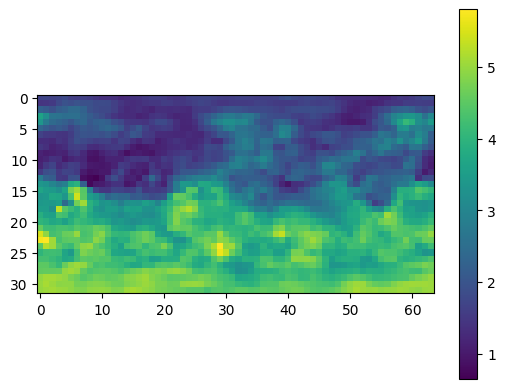

In [56]:
plt.imshow(lsci_upper.reshape(nlat, nlon))
plt.colorbar()

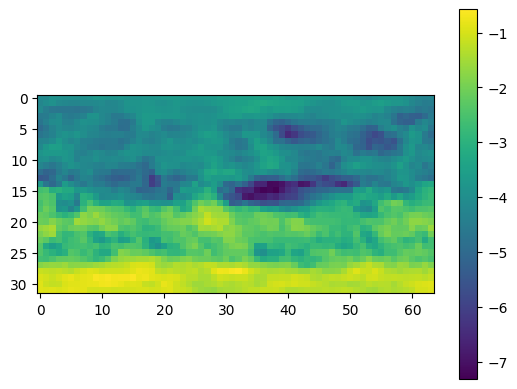

In [55]:
plt.imshow(lsci_lower.reshape(nlat, nlon))
plt.colorbar()

In [349]:
def phi_resample2(xval, xtest, rval_fno, n_samp, n_slice, rng,
                 alpha, depth_fn, local_fn, lam):
    n = rval_fno.shape[0]
    npc = rval_fno.shape[1]//2
    key1, key2, key3 = random.split(rng, 3)

    # renormalize
    xval = xval / jnp.sqrt(jnp.mean(xval**2, axis = 0))
    xtest = xtest / jnp.sqrt(jnp.mean(xtest**2, axis = 0))
    local_weights = lweights(xval.squeeze(), xtest.squeeze()[None,], 0.1)[0]

    # generate
    pca_state = pcax.fit(rval_fno, npc)
    rval_fpc = pcax.transform(pca_state, rval_fno)
    # print(rval_fpc.shape)

    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_fpc) - 0.1, jnp.max(rval_fpc) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_fpc, quants, local_weights / jnp.sum(local_weights))
    # print(samp_cdfs.shape)
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T

    # print(samp_phi.shape)
    samp_phi = pcax.recover(pca_state, samp_phi)

    # check inclusion
    phi = phi_slice(key2, nlat*nlon, n_slice)
    qval, local_weights = phi_quantile(rval_fno @ phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_fno @ phi, local_weights, depth_fn)
    
    return samp_phi, dphi, qval

In [306]:
rval_fno.reshape(-1, nlat*nlon).shape

(1824, 2048)

In [321]:
## LSCI 1
k = 200
dphi_max = 0
while dphi_max == 0:
    rng, key1, key2 = random.split(rng, 3)
    local_ens, dphi, qval = phi_resample2(xval.reshape(-1, 1, nlat*nlon), 
                                         xtest[k].reshape(1, nlat*nlon),
                                         rval_fno.reshape(-1, nlat*nlon), 
                                         nsamp, nslice, key1,
                                         alpha, 'tukey', 'dexp', 5)
    dphi_max = jnp.sum(dphi > qval)

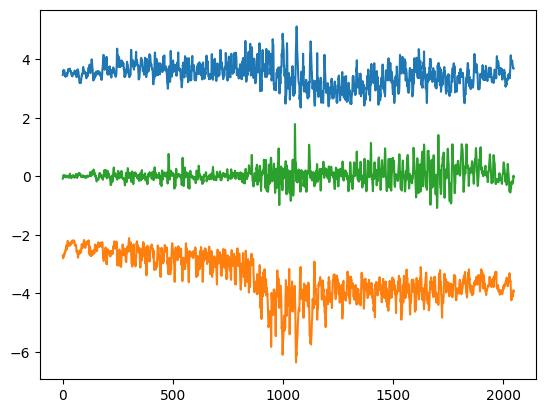

In [327]:
uval = jnp.quantile(local_ens, 0.95, axis = 0)
lval = jnp.quantile(local_ens, 0.05, axis = 0)

plt.plot(uval)
plt.plot(lval)
plt.plot(rtest_fno[k])
plt.show()

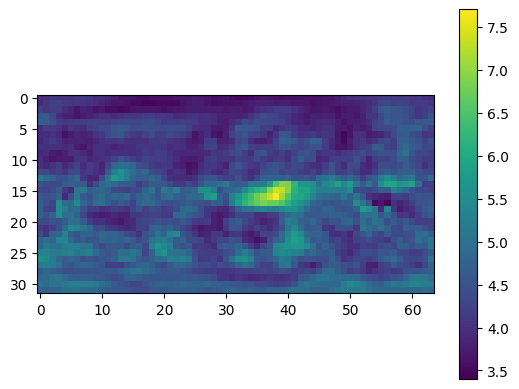

In [259]:
plt.imshow(jnp.abs(uval-lval).reshape(nlat, nlon))
plt.colorbar()
plt.show()

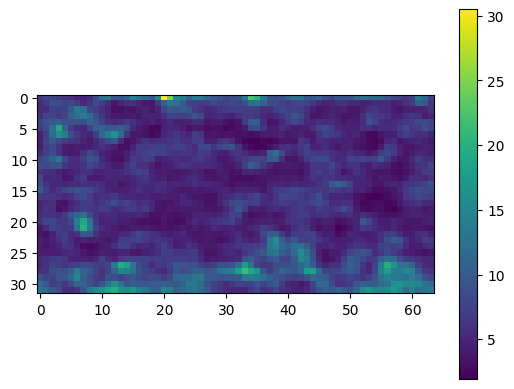

In [206]:
plt.imshow(jnp.abs(pdon_upper[k] - pdon_lower[k]).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [353]:
cover = cover[0:1138]
width = width[0:1138]

In [355]:
# metrics
# sigma = sd[1:
sigma = jnp.mean(rtest_fno[0:1138]**2, axis = 1)
cover_mean = np.round(np.mean(cover > 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_corr_mean = np.zeros(nmod)
cover_corr_std = np.zeros(nmod)
width_corr_mean = np.zeros(nmod)
width_corr_std = np.zeros(nmod)
for i in range(nmod):
    corr = np.corrcoef(np.vstack([cover[:,i] > 0.99, sigma]))[0,1]
    cover_corr_mean[i] = np.mean(corr)
#     cover_corr_std[i] = 2*np.std(corr)
    
    corr = np.corrcoef(np.vstack([width[:,i], sigma]))[0,1]
    width_corr_mean[i] = np.mean(corr)
    width_corr_std[i] = 2*np.std(corr)

metrics_mean = np.vstack([
    cover_mean,
    cover_corr_mean,
    width_mean,
    width_corr_mean
]).T

/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [356]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)

0.982 & -0.003 & 3.928 & 0.177 \\
0.962 & 0.005 & 3.806 & 0.140 \\
1.000 & -- & 8.213 & -- \\
1.000 & -- & 8.096 & -- \\
1.000 & -- & 8.584 & -- \\
1.000 & -- & 12.410 & 0.147 \\
1.000 & -- & 5.790 & -0.365 \\
0.373 & -0.413 & 4.503 & 0.015 \\
